# **Image Classification for Cats and Dogs using Transfer Learning**
In the previous notebook, we developed a Convolutional Neural Network (CNN) to classify images of cats and dogs. The model demonstrated promising results, but we believe there is room for improvement. In this notebook, we will focus on enhancing the performance of the model using techniques such as data augmentation and fine-tuning. By implementing transfer learning, we aim to achieve a more robust and accurate model for image classification. We will also evaluate the impact of these techniques on the model's accuracy and loss. Our ultimate goal is to build a highly accurate and efficient model for classifying images of cats and dogs, which can be applied to various applications such as animal shelters, veterinary clinics, and online pet marketplaces.

### **A little about transfer learning**

To create a robust and accurate image classification model, we will be using a popular deep learning technique called Transfer Learning. In this technique, we use a pre-trained neural network as the starting point and then fine-tune it on our own data to perform a specific task.
*  We will be using the **VGG16 model** as our base model. 


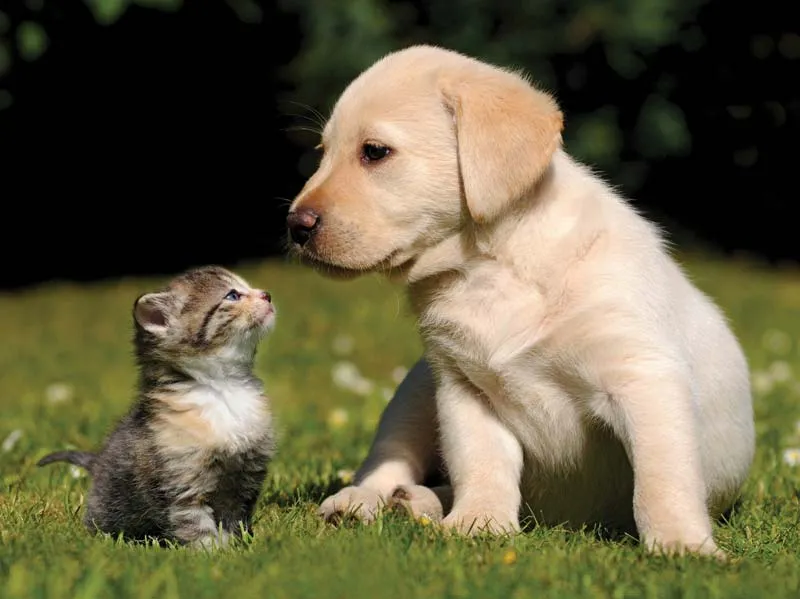


Let's start by initialising the environment we will be working in, this notebook was run on Kaggle kernels because of the high computational power needed for image processing and CNN architectures, so it is recommended to run it in a similar isolated environment.


Next we load the dataset we will use for this classification problem:

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.3443.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.10728.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.790.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.10063.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.2618.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.2875.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.5288.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.4223.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.4253.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.7153.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.2888.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.7275.jpg
/kaggle/input/dog-vs-cat-fastai/dogscats/dogscats/valid/dogs/dog.10894.jpg
/kaggle/input/dog-vs-cat-fastai/dogs

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import tensorflow as tf
from tensorflow import keras

To ensure that the results of the project are reproducible, meaning that others can replicate the findings. It also sets the Python hash seed to make sure the hash values of objects in your code are deterministic, which can impact the order of iteration and therefore the outcome of operations that depend on the order.

In [4]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

## **Pipeline and Preprocessing**

The code loads the training and validation sets of image data and applies a data pipeline to prepare the data for deep learning models.

The image_dataset_from_directory function is used to load the data from the specified directory paths. The labels are inferred from the directory structure and the label mode is set to binary. The images are resized to 128x128 pixels and interpolated using the nearest neighbor method. The batch size is set to 32 and the data is shuffled in the training set but not in the validation set.

The convert_to_float function is defined to convert the pixel values of the images to float32 data type. The AUTOTUNE constant is defined to allow TensorFlow to automatically determine the optimal buffer size for prefetching data, which can improve performance.

The data pipeline applies the convert_to_float function to each image and label pair, caches the results in memory, and prefetches the next batch of data to speed up training. This prepares the data for efficient training of deep learning models.

In [5]:
# Load training and validation sets
from tensorflow.keras.preprocessing import image_dataset_from_directory

ds_train_ = image_dataset_from_directory(
    '/kaggle/input/dog-vs-cat-fastai/dogscats/train',
    labels='inferred',
    label_mode='binary',
    image_size=[256, 256],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

ds_valid_ = image_dataset_from_directory(
    '/kaggle/input/dog-vs-cat-fastai/dogscats/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[256, 256],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 23000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


The output indicates that there are a total of 23,000 image files belonging to 2 classes in the training set, and 2,000 image files belonging to the same 2 classes in the validation set.

This information is important for understanding the size and structure of the data being used in the project. It also confirms that the image_dataset_from_directory function was able to correctly identify and load the data from the specified directories.

Let's explore how are we preprocessing the data by showing the image and its representation in a normalized array: 

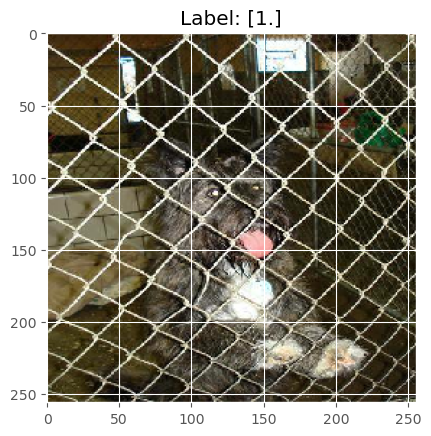

[[[0.73333335 0.65882355 0.5294118 ]
  [0.25882354 0.18431373 0.05882353]
  [0.26666668 0.19215688 0.06666667]
  ...
  [0.2392157  0.16862746 0.09019608]
  [0.20784315 0.13725491 0.05882353]
  [0.6745098  0.6156863  0.53333336]]

 [[0.27450982 0.20000002 0.07450981]
  [0.23137257 0.15686275 0.03137255]
  [0.27058825 0.19607845 0.07058824]
  ...
  [0.627451   0.5686275  0.48627454]
  [0.882353   0.8235295  0.7411765 ]
  [0.7803922  0.73333335 0.64705884]]

 [[0.25882354 0.18431373 0.05882353]
  [0.25490198 0.18039216 0.0627451 ]
  [0.21960786 0.14509805 0.02745098]
  ...
  [1.         1.         0.909804  ]
  [0.854902   0.8235295  0.73333335]
  [0.18823531 0.15686275 0.06666667]]

 ...

 [[0.23137257 0.17254902 0.01176471]
  [0.41960788 0.36078432 0.20784315]
  [0.37254903 0.3137255  0.16078432]
  ...
  [0.0627451  0.08235294 0.00392157]
  [0.04313726 0.05882353 0.        ]
  [0.20392159 0.21568629 0.14117648]]

 [[0.32941177 0.27450982 0.12156864]
  [0.30588236 0.2509804  0.09803922]


In [6]:
# get a batch of images and labels
for images, labels in ds_train.take(1):
    # select a random image from the batch
    idx = np.random.randint(images.shape[0])
    image = images[idx].numpy()
    label = labels[idx].numpy()

    # display the image and label
    plt.imshow(image)
    plt.title('Label: ' + str(label))
    plt.show()

    # display the image representation as an array
    print(image)

Everything seems to be working fine, so we can move on to the ConvNet architecture.

## **Transfer Learning: Defining a base model**

Transfer learning is a powerful technique that enables us to leverage pre-trained deep neural networks and fine-tune them on new datasets to solve different problems, with minimal amounts of data and computational resources. In this project, we will use transfer learning to create a high-performance image classifier that can differentiate between cats and dogs, using the ImageNet pre-trained model as our base model. We will also explore the impact of data augmentation and fine-tuning on the model's accuracy and loss. The goal is to demonstrate how transfer learning can be used to build accurate image classifiers for real-world applications, even with limited resources.

In [7]:
from keras import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

### **VGG16 Model**
To initialize the VGG16 model with its pre-trained weights, we set weights='imagenet' when calling the constructor. We also set include_top=False to exclude the fully-connected layers at the end of the model, which we will replace with our own layers for our specific task of cat vs dog classification. Finally, we set input_shape=(256,256,3) to define the expected input shape of our images.

After initializing the model, we call conv_base.summary() to print out the architecture of the VGG16 model and confirm that it has been set up correctly as our base model.

In [8]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)
conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

## **Model Architecture: Defining a custom CNN model with pre-trained VGG16 base**

We are defining a custom CNN model with a pre-trained VGG16 base to improve the accuracy of our image classification task. The pre-trained VGG16 base has already learned some basic features from millions of images, and we can leverage this knowledge to extract useful features from our own image dataset. We will be adding our own classification head on top of the pre-trained model, consisting of several fully connected layers with dropout regularization. We will also be freezing the weights of the pre-trained model to avoid overfitting and to speed up the training process. Finally, we will be using the binary cross-entropy loss function and Adam optimizer to train our model, and setting up early stopping to prevent overfitting.






In [9]:
# Freeze the weights of the pre-trained model
for layer in conv_base.layers:
    layer.trainable = False

# Add your own classification head
model = keras.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Set up early stopping
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

# Compile the model
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

This code fits the compiled model to the training data and evaluates it on the validation data for a specified number of epochs. It also stores the training and validation metrics at each epoch in the **history** variable.

In [10]:
history = model.fit(ds_train_, epochs=20, validation_data=ds_valid_) 

Epoch 1/20
360/360 [==============================] - 135s 335ms/step - loss: 1.5699 - binary_accuracy: 0.9397 - val_loss: 0.3077 - val_binary_accuracy: 0.9580
Epoch 2/20
360/360 [==============================] - 76s 208ms/step - loss: 0.3120 - binary_accuracy: 0.9647 - val_loss: 0.0821 - val_binary_accuracy: 0.9725
Epoch 3/20
360/360 [==============================] - 76s 206ms/step - loss: 0.1416 - binary_accuracy: 0.9754 - val_loss: 0.0682 - val_binary_accuracy: 0.9710
Epoch 4/20
360/360 [==============================] - 77s 209ms/step - loss: 0.0871 - binary_accuracy: 0.9807 - val_loss: 0.0728 - val_binary_accuracy: 0.9760
Epoch 5/20
360/360 [==============================] - 75s 205ms/step - loss: 0.0621 - binary_accuracy: 0.9857 - val_loss: 0.0648 - val_binary_accuracy: 0.9755
Epoch 6/20
360/360 [==============================] - 76s 207ms/step - loss: 0.0366 - binary_accuracy: 0.9901 - val_loss: 0.0792 - val_binary_accuracy: 0.9780
Epoch 7/20
360/360 [=========================

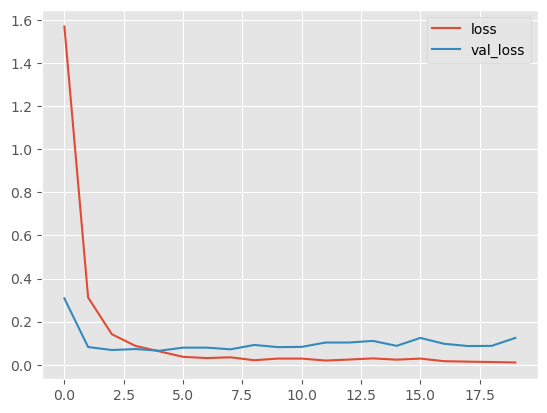

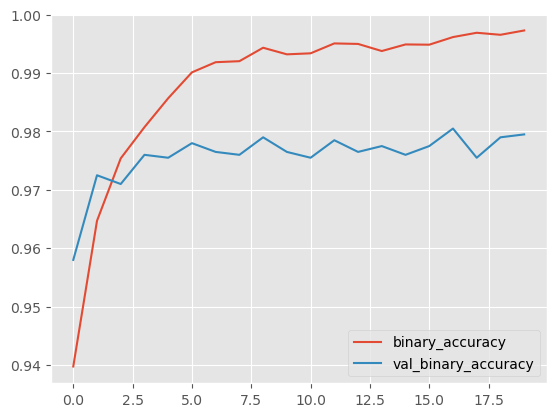

In [12]:
# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [26]:
# Save the model
model.save("cat_dog_classifier.h5")

### **Results of the model**

* The model was trained for 20 epochs, and its performance was measured on both the training set and the validation set after each epoch.

* The loss function used is binary cross-entropy, which is a standard loss function for binary classification problems. The binary accuracy metric is also used to evaluate the model's performance.

* Overall, the model achieved high accuracy on both the training and validation sets, with the binary accuracy exceeding 97% for most epochs. 

## **Performance of the model**

This code is evaluating the performance of a model on a validation dataset by computing a confusion matrix and some performance metrics such as precision, recall, and accuracy. Here is a summary of what the code is doing:

In [18]:
# Extract the true labels and predicted labels from the validation dataset
y_true = []
y_pred = []
for x_val, y_val in ds_valid_:
    y_true.extend(y_val.numpy())
    y_pred.extend(tf.squeeze(model.predict(x_val)).numpy().round())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

1/1 [==============================] - 0s 246ms/step
[[983  17]
 [ 24 976]]


Those results indicate that your model predicted:
* 983 true negatives, 
* 976 true positives, 
* 17 false positives, 
* 24 false negatives.

Using this information, you can compute various evaluation metrics such as accuracy, precision, recall, and F1-score. Here's how:

In [19]:
# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Compute the precision, recall, and accuracy
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.9828801611278952
Recall: 0.976
Accuracy: 0.9795


The output of this code shows that the model has a high precision, recall, and accuracy, which indicates that it performs well on the validation dataset. The precision is 0.98, which means that 98% of the predicted positive cases are actually positive. The recall is 0.976, which means that 97.6% of the true positive cases are correctly identified by the model. The accuracy is 0.9795, which means that 97.95% of the predictions are correct.

Let's see if this is the case by including some images where the previous model failed: 

## **Final Testing**

1/1 [==============================] - 0s 25ms/step


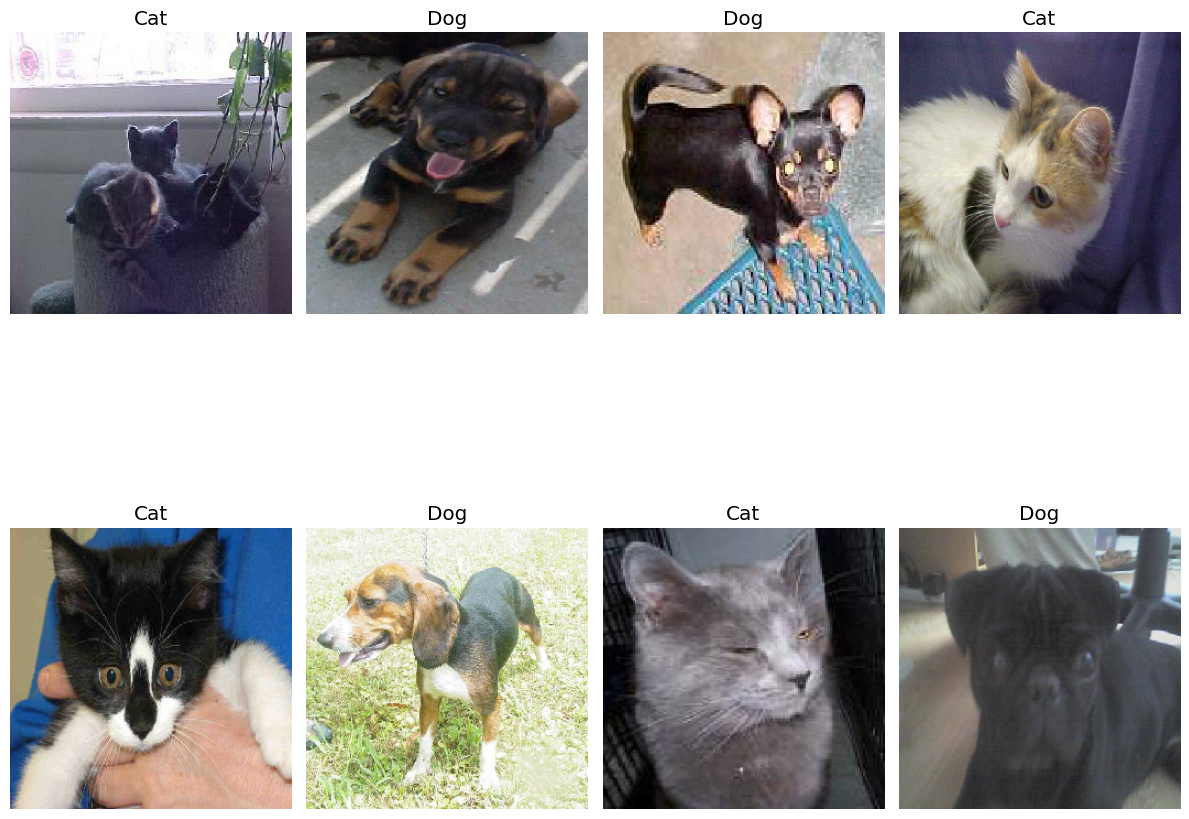

In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

validation_images_dir = '/kaggle/input/dog-vs-cat-fastai/dogscats/sample/valid'
class_names = ['cats', 'dogs']

# Load and shuffle the image file names
image_files = []
for class_name in class_names:
    class_dir = os.path.join(validation_images_dir, class_name)
    for img_name in os.listdir(class_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(class_dir, img_name)
            image_files.append(img_path)
random.shuffle(image_files)

# Create a subplot grid of 2x4
fig, axes = plt.subplots(2, 4, figsize=(12, 12))

# Loop through each axis and load the image
for i, ax in enumerate(axes.flat):
    img_path = image_files[i]
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    ax.imshow(img_array.astype(np.uint8))
    ax.axis('off')
    
    # Predict the class probabilities for the image
    img_batch = np.expand_dims(img_array, axis=0)
    class_probabilities = model.predict(img_batch)

    # Print the predicted class probabilities
    if class_probabilities[0] > 0.5:
        ax.set_title('Dog')
    else:
        ax.set_title('Cat')
plt.tight_layout()
plt.show()

This time, the model does correctly identify the cats and dogs without errors. In the previous notebook we saw how the previous model had failures with the group of cats in the first image, that is why for the current model we enlarged the batch_size and the size of the images, so it was expected that the processing of the images would produce better results, and it did.

1/1 [==============================] - 0s 26ms/step


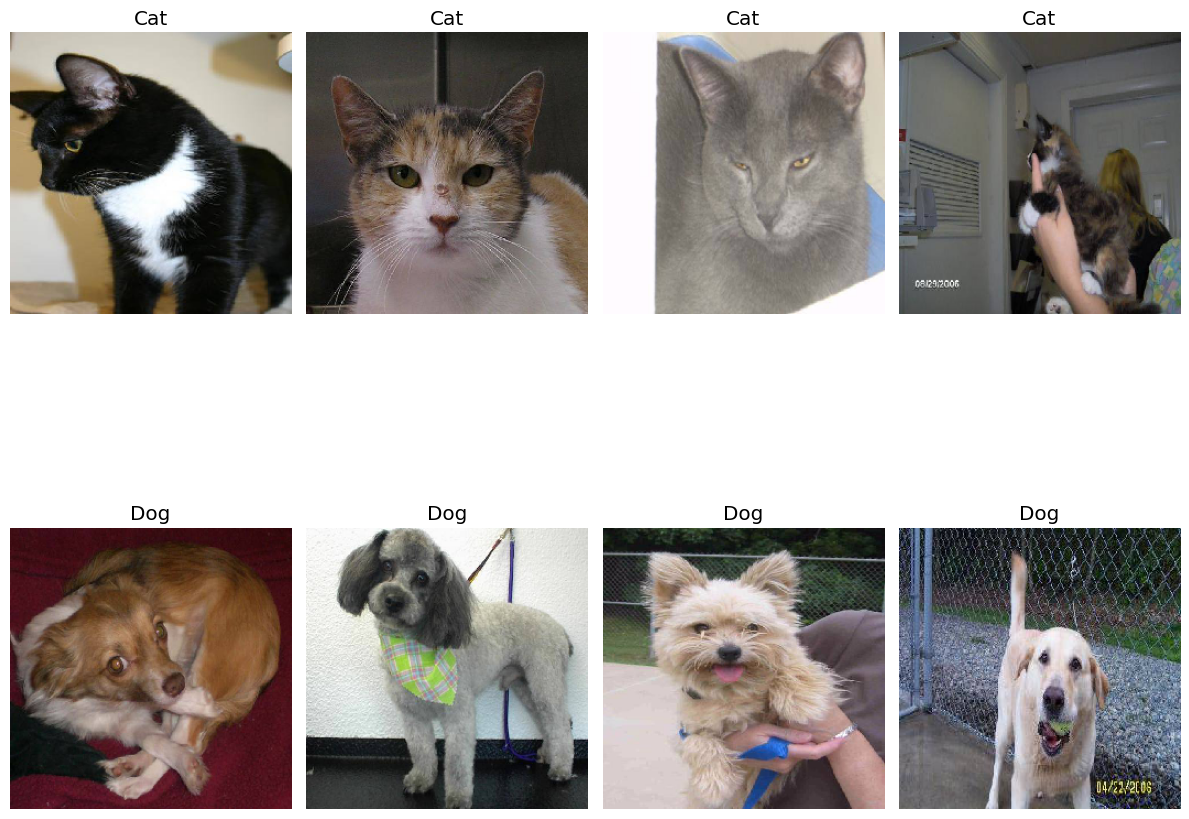

In [25]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

validation_images_dir_2 = '/kaggle/input/dog-vs-cat-fastai/dogscats/valid'
class_names = ['cats', 'dogs']

# Load and shuffle the image file names
image_files = []
for class_name in class_names:
    class_dir = os.path.join(validation_images_dir_2, class_name)
    class_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    random.shuffle(class_files)
    image_files.extend([os.path.join(class_dir, f) for f in class_files[:4]])

# Create a subplot grid of 2x4
fig, axes = plt.subplots(2, 4, figsize=(12, 12))

# Loop through each axis and load the image
for i, ax in enumerate(axes.flat):
    img_path = image_files[i]
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    ax.imshow(img_array.astype(np.uint8))
    ax.axis('off')
    
    # Predict the class probabilities for the image
    img_batch = np.expand_dims(img_array, axis=0)
    class_probabilities = model.predict(img_batch)

    # Print the predicted class probabilities
    if class_probabilities[0] > 0.5:
        ax.set_title('Dog')
    else:
        ax.set_title('Cat')
plt.tight_layout()
plt.show()

Again, the model succeeds in correctly identifying all the inputs to this validation set. 

# **Summary and Conclusions**

In this notebook, we trained a Convolutional Neural Network (CNN) model using transfer learning (VGG16) to classify images of cats and dogs. The model was trained for 20 epochs using the training dataset, and the results showed that the model has learned to classify the images with an accuracy above 97%.

The precision score of the model was 0.9828, which suggests that when the model predicts an image to be a cat or a dog, it is correct 98.28% of the time. The recall score was 0.976, which indicates that the model can identify 97.6% of the actual cats and dogs in the dataset.

Overall, the results suggest that the model can accurately classify images of cats and dogs, with a high level of precision and recall.

# **Next Steps**
* **Data Augmentation**: We could augment the dataset with additional images and use techniques such as rotation, flipping, and scaling to increase the variability of the dataset. This could help the model to better generalize to new, unseen images.

* **Hyperparameter Tuning**: We could tune the hyperparameters of the model to optimize its performance. This could involve adjusting the learning rate, the number of filters, the kernel size, and other parameters. We could use techniques such as grid search or random search to explore the hyperparameter space.

* **Model Architecture**: We could explore different model architectures, such as deeper or wider models, to improve the accuracy of our model. We could also try using transfer learning, where we use a pre-trained model as a starting point and fine-tune it on our dataset.

* **Deploying the Model**: Once we have a model that performs well on our dataset, we could deploy it in a production environment. This could involve creating an API or web application that allows users to upload images and receive predictions from our model.

Thanks for reading this notebook!

**Edwar Benavente**